
📌 Step 1: Predicting plant type...
1/1 [==============================] - 0s 263ms/step

🌱 Plant Type: Tomato

📌 Step 2: Classifying disease...
1/1 [==============================] - 0s 230ms/step

🦠 Disease Detected: Tomato_Late_blight

📌 Step 3: Visualizing infection areas...

image 1/1 C:\Users\lenovo\Desktop\EU\sem 2\ML\Testing_img\Tomatoabc1.png: 416x320 11 infecteds, 291.5ms
Speed: 6.4ms preprocess, 291.5ms inference, 5.4ms postprocess per image at shape (1, 3, 416, 320)


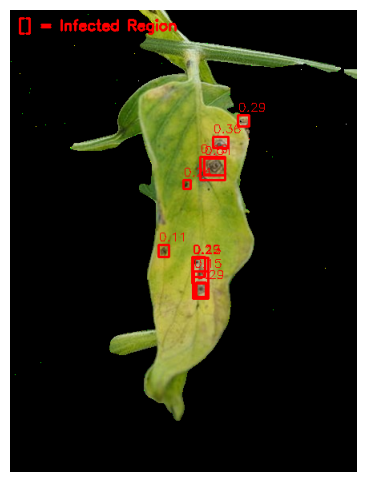


📌 Step 4: Recommending cure...
Enter your region/country: Philippines
Choose treatment type (Organic/Chemical): Organic

🧪 Recommended Cure (organic):
Cure found, visit the link for details.
💊 Dosage/Method: See full link for details.
🔗 Source: https://asset.library.wisc.edu/1711.dl/G6C6SHCIR36WQ9E/R/file-a9e03.pdf


In [2]:
# Notebook 4: Complete Plant Disease Detection Pipeline (with Cure Recommendation + Web Fallback)

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd
import os

# Web search libraries
from googlesearch import search
import requests
from bs4 import BeautifulSoup

# ---------- Load Models ----------
plant_type_model = load_model(r"C:\Users\lenovo\Desktop\EU\sem 2\ML\Plant health\Model redefined\best_plant_type_model.keras")
plant_classes = ['Bell_pepper', 'Potato', 'Tomato']

disease_model = load_model(r"C:\Users\lenovo\Desktop\EU\sem 2\ML\Plant health\Model redefined\best_cnn_model.keras")
disease_classes = [
   
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy',
   
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
  
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

detection_model = YOLO(r"C:\Users\lenovo\Desktop\EU\sem 2\ML\Plant health\Model redefined\best.pt")

# ---------- Load Cure Dataset ----------
dataset_path = r"C:\Users\lenovo\Desktop\EU\sem 2\ML\Plant health\Model redefined\Cure3.xlsx"
cure_df = pd.read_excel(dataset_path)
cure_df.columns = cure_df.columns.str.strip()

# ---------- Utility Functions ----------
def preprocess_image(img_path, target_size=(128, 128)):
    image = Image.open(img_path).convert("RGB")
    image = image.resize(target_size)
    image = img_to_array(image)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

def predict_plant_type(img_path):
    image = preprocess_image(img_path)
    preds = plant_type_model.predict(image)
    return plant_classes[np.argmax(preds)]

def predict_disease(img_path):
    image = preprocess_image(img_path)
    preds = disease_model.predict(image)
    return disease_classes[np.argmax(preds)]

def show_bounding_boxes(img_path):
    img = cv2.imread(img_path)
    results = detection_model(img_path, conf=0.1)[0]
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf)
        label = f"{conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(img, "[] = Infected Region", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# ---------- Web Cure Fallback ----------
def get_external_cure(disease, plant, region, treatment_type):
    print("🔎 Searching web for cure...")
    query = f"{plant} {disease} {treatment_type} treatment agriculture site:edu OR site:gov"
    urls = list(search(query, num_results=5))

    for url in urls:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')
            text = soup.get_text(separator='\n').strip()

            lines = [line for line in text.split('\n') if disease.lower() in line.lower()]
            summary = "\n".join(lines[:3]) if lines else "Cure found, visit the link for details."

            return {
                "Disease": disease,
                "Plant": plant,
                "Region": region,
                "Treatment Type": treatment_type,
                "Cure Description": summary[:500],
                "Link to treatment": url,
                "Dosage/Method": "See full link for details.",
                "Source": url
            }
        except Exception:
            continue
    return None

# ---------- Append to Dataset ----------
def append_to_excel(entry_dict, file_path):
    df = pd.read_excel(file_path)
    df = pd.concat([df, pd.DataFrame([entry_dict])], ignore_index=True)
    df.to_excel(file_path, index=False)

# ---------- Search Cure Logic ----------
def get_local_or_global_cure(disease, plant, region, treatment_type):
    disease = disease.strip().lower()
    plant = plant.strip().lower()
    region = region.strip().lower()
    treatment_type = treatment_type.strip().lower()

    local = cure_df[
        (cure_df["Disease"].str.strip().str.lower() == disease) &
        (cure_df["Plant"].str.strip().str.lower() == plant) &
        (cure_df["Region"].str.strip().str.lower() == region) &
        (cure_df["Treatment Type"].str.strip().str.lower() == treatment_type)
    ]
    if not local.empty:
        return local.iloc[0].to_dict()

    global_match = cure_df[
        (cure_df["Disease"].str.strip().str.lower() == disease) &
        (cure_df["Plant"].str.strip().str.lower() == plant) &
        (cure_df["Treatment Type"].str.strip().str.lower() == treatment_type)
    ]
    if not global_match.empty:
        return global_match.iloc[0].to_dict()

    # Fallback to external web search
    external_cure = get_external_cure(disease, plant, region, treatment_type)
    if external_cure:
        append_to_excel(external_cure, dataset_path)
        return external_cure

    return None

# ---------- Main Pipeline ----------
def full_diagnosis_pipeline(img_path):
    print("\n📌 Step 1: Predicting plant type...")
    plant_type = predict_plant_type(img_path)
    print(f"\n🌱 Plant Type: {plant_type}")

    print("\n📌 Step 2: Classifying disease...")
    disease = predict_disease(img_path)
    print(f"\n🦠 Disease Detected: {disease}")

    print("\n📌 Step 3: Visualizing infection areas...")
    show_bounding_boxes(img_path)

    print("\n📌 Step 4: Recommending cure...")
    region = input("Enter your region/country: ")
    treatment_type = input("Choose treatment type (Organic/Chemical): ")
    cure = get_local_or_global_cure(disease, plant_type, region, treatment_type)

    if cure:
        print(f"\n🧪 Recommended Cure ({cure['Treatment Type']}):\n{cure['Cure Description']}")
        print(f"💊 Dosage/Method: {cure['Dosage/Method']}")
        print(f"🔗 Source: {cure['Link to treatment']}")
    else:
        print("❌ No cure found locally or globally. Please consult a local agronomist.")

# ---------- Run ----------
test_image = r"C:\Users\lenovo\Desktop\EU\sem 2\ML\Testing_img\Tomatoabc1.png"
full_diagnosis_pipeline(test_image)
